<b><span style="color:green; font-size:150%">Micro-Business Density forecast:
with focus on feature engineering of census data and time-series based data</span></b>


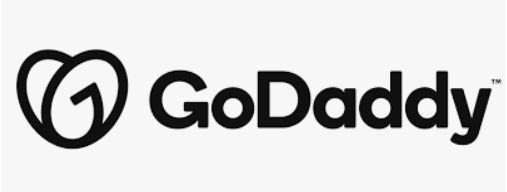

<b><span style="color:green; font-size:120%">If you want to check simple version with full modeling code, please refer to 
https://www.kaggle.com/code/kimtaehun/simple-version-predict-3-135-county-one-by-one</span></b> 

# **<span style="color:#F7B2B0;">Problem Statment & workflow summary</span>**
In this competition we are given 3,135 (the unique number of county) time-series of length 39 (time span). With those data, we should predict We must predict microbusiness density for the 8 months November 2022 thru June 2023. 

This is not a easy task. **Time span is too short** for making a prediction. As there are **only 39 data points for each county**, our ML model couldn't learn a lot from historical data. 

The workflow would be like this diagram:
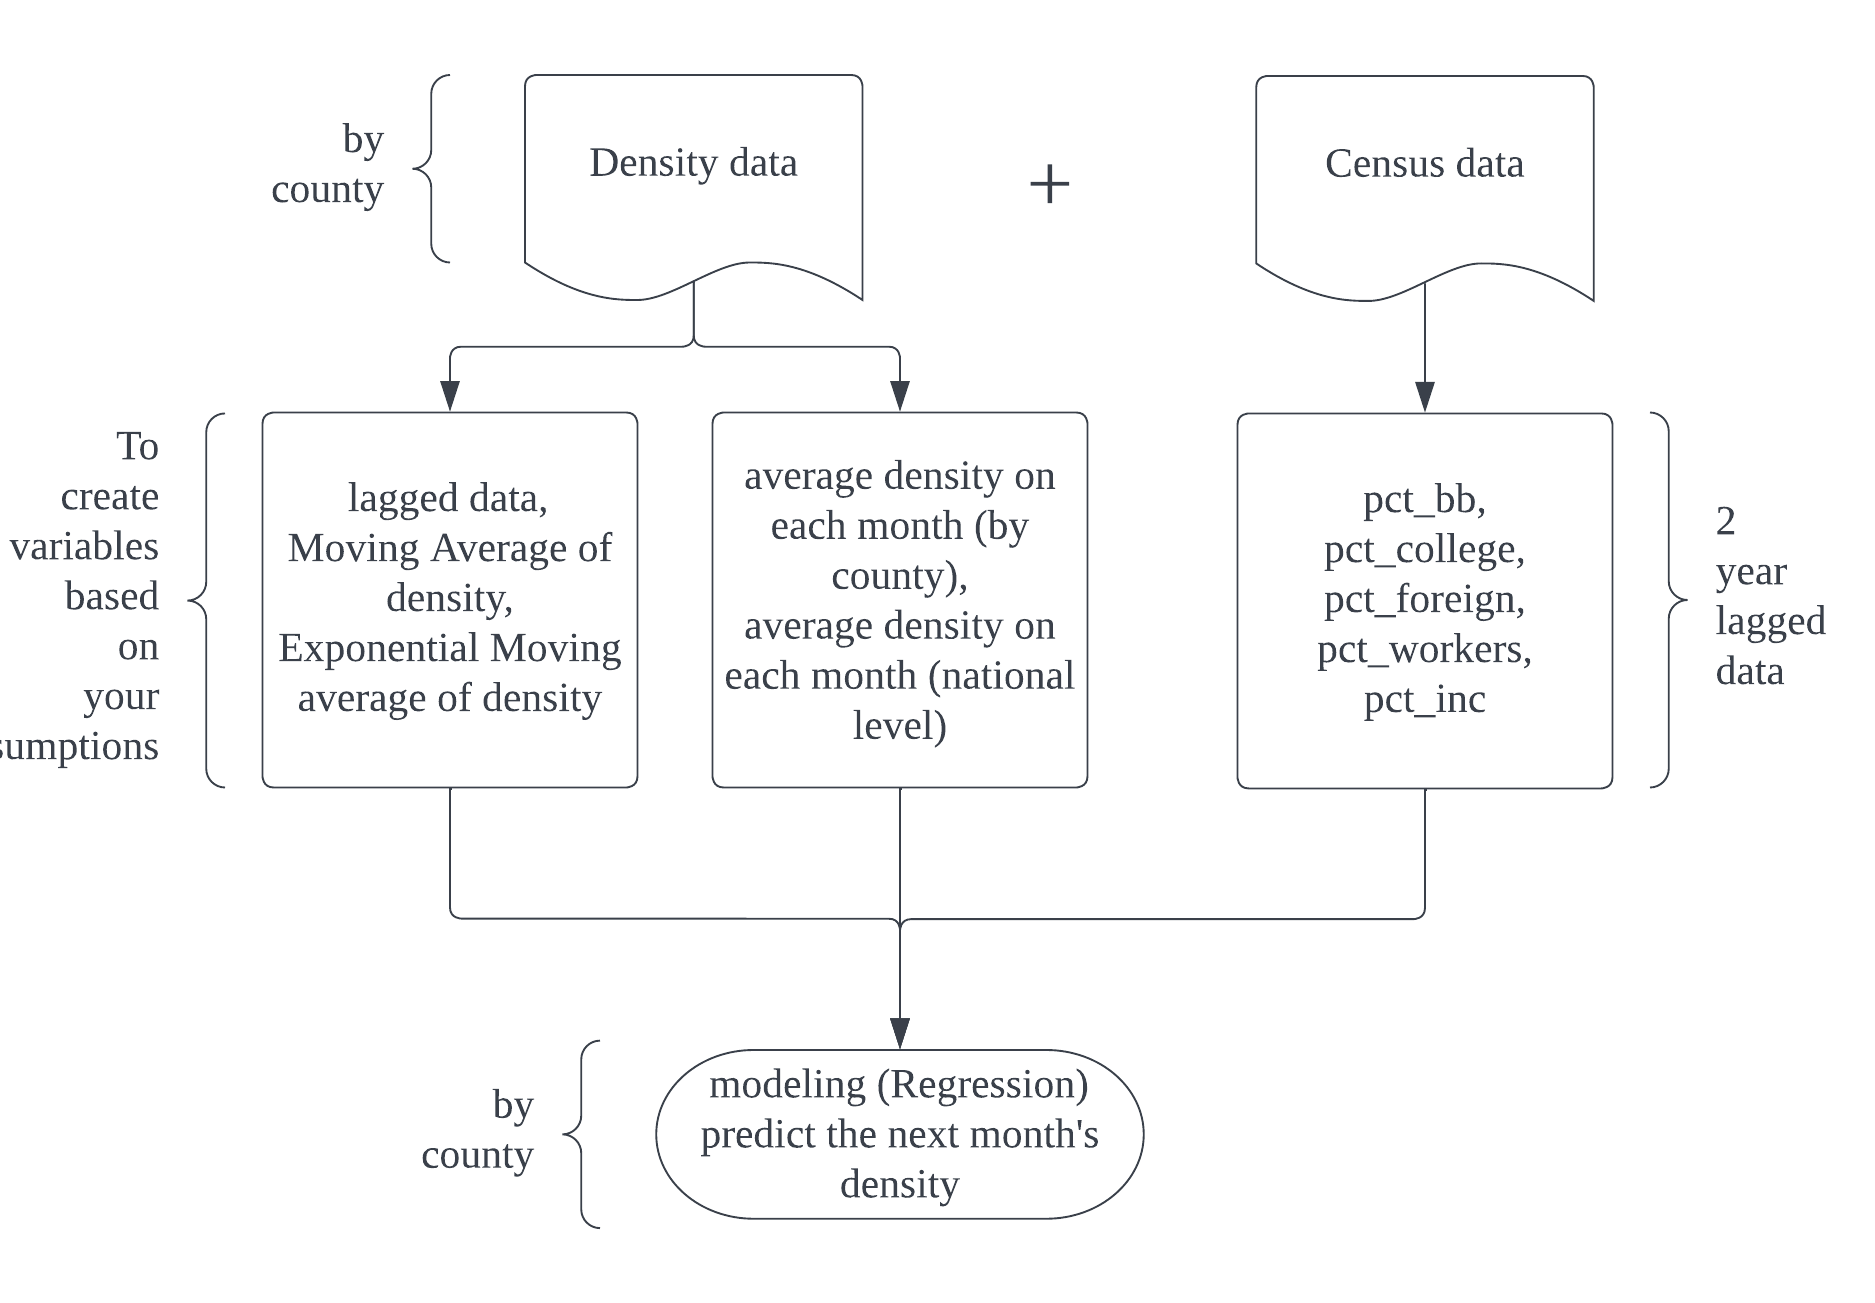

Even though this is a tough task, we should find the best model. I think the key is 'feature engineering'. What kind of variables can we add to this model? 



# **<span style="color:#F7B2B0;">feature engineering overview</span>**
As we have time-series data, we can make **time-series based variables**. 
1) lag data : The lag time is the time between the two time series you are correlating. It is reasonable to think that yesterday's stock price would affect today's stock price. :)

2) moving average : The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 2days, 3days, a week etc...


3) weighted moving average / Exponetioanl moving Average: Exponential Moving Average (EMA) is similar to Simple Moving Average (SMA), measuring trend direction over a period of time. However, whereas SMA simply calculates an average of price data, EMA applies more weight to data that is more current.


Also, the census data is given. As it noted,all fields have a two year lag to match what information was avaiable at the time a given microbusiness data update was published.

- pct_bb_[year] - The percentage of households in the county with access to broadband of any type. 
- pct_college_[year] - The percent of the population in the county over age 25 with a 4-year college degree.
- pct_foreign_born_[year] - The percent of the population in the county born outside of the United States. 
- pct_it_workers_[year] - The percent of the workforce in the county employed in information related industries.
- median_hh_inc_[year] - The median household income in the county.

Here's choropleth map of The percentage of households in the county with access to broadband of any type (pct_bb_[year]) in 2019. You can find the related code below!
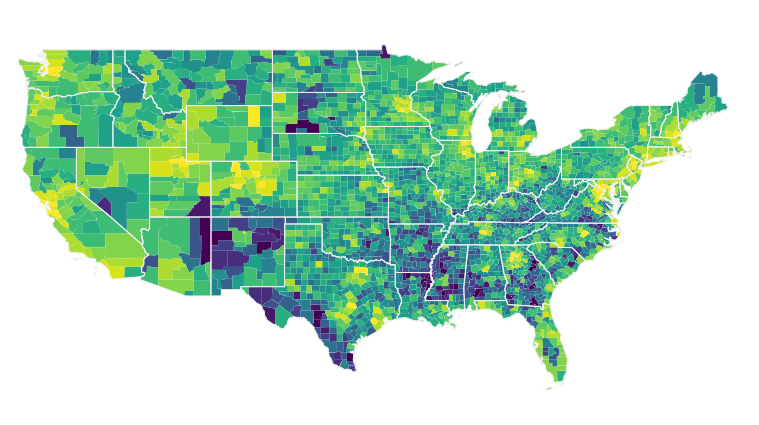

As it is reasonble that these factors could affect the number of micro-business and the number of young people in each county, I will include those variables. 


Finally,we should consider **'national-wide' and 'state-wide' factors**, like average micro-business density in each state on each month or national average micro-business density each month. Therefore, I will also create these variables and try to use it for prediction.

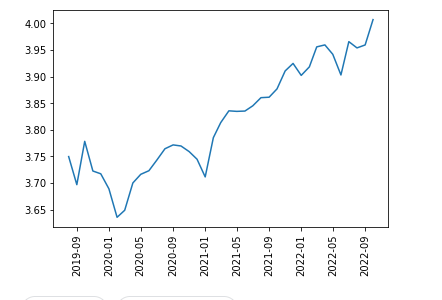

It seems like micro-business was affected by Covid-19 (where it dropped dramatically). However, 4 out of 100 people over the age of 18 in the given county running their own business Now.

# **<span style="color:#F7B2B0;">Modeling overviews</span>**

There are multiple candidate models for this time series forecasting.
As time span is relatively short, complicated model would be avoided.
I will test simple linear regression, regression with regularizations like Ridge, Lasso or both (Enet).
At the same time, I will try tree-based model like Random Forest, XGB and LGBM.

the below results is one of the example of density forecasting. the average SMAPE is quite low in this case (New London County)
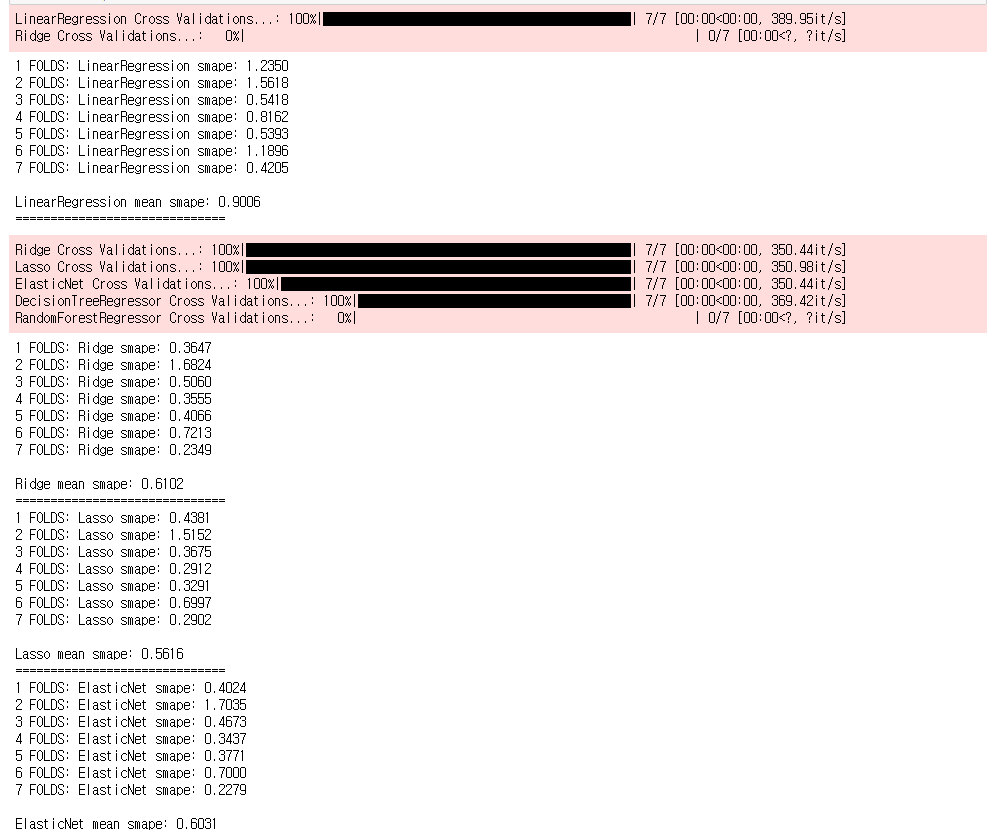


So I believe you could build strong model based on this code. Hope it will be helpful for you guys, and please **UPVOTE** this post for the next version!

In terms of modeling, I'd like to point one thing here. YOU should be careful when it comes to train/test split for CV.
TimeSeries split method should be used for avoiding data leakage (cheating).

I will show you how to use this technic easily in the following code.

Time Series Split Example:
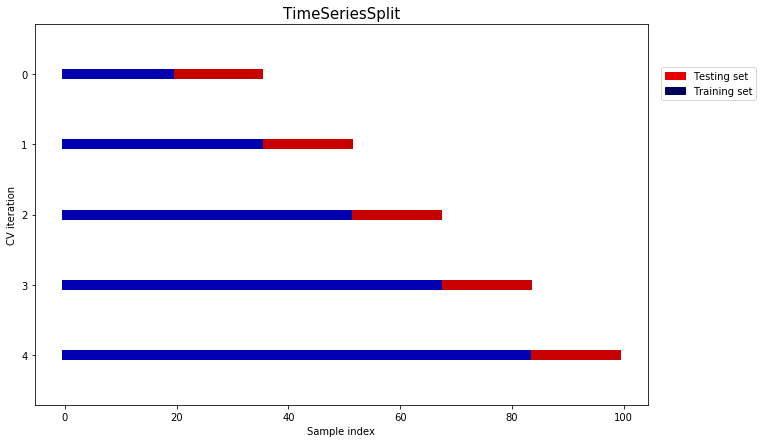

## What's Next?
Each county's time series might has different trend. 
Theoretically, the best way is test each time series and choose the best model.
(It might take a lot of time, as it should train tons of models)

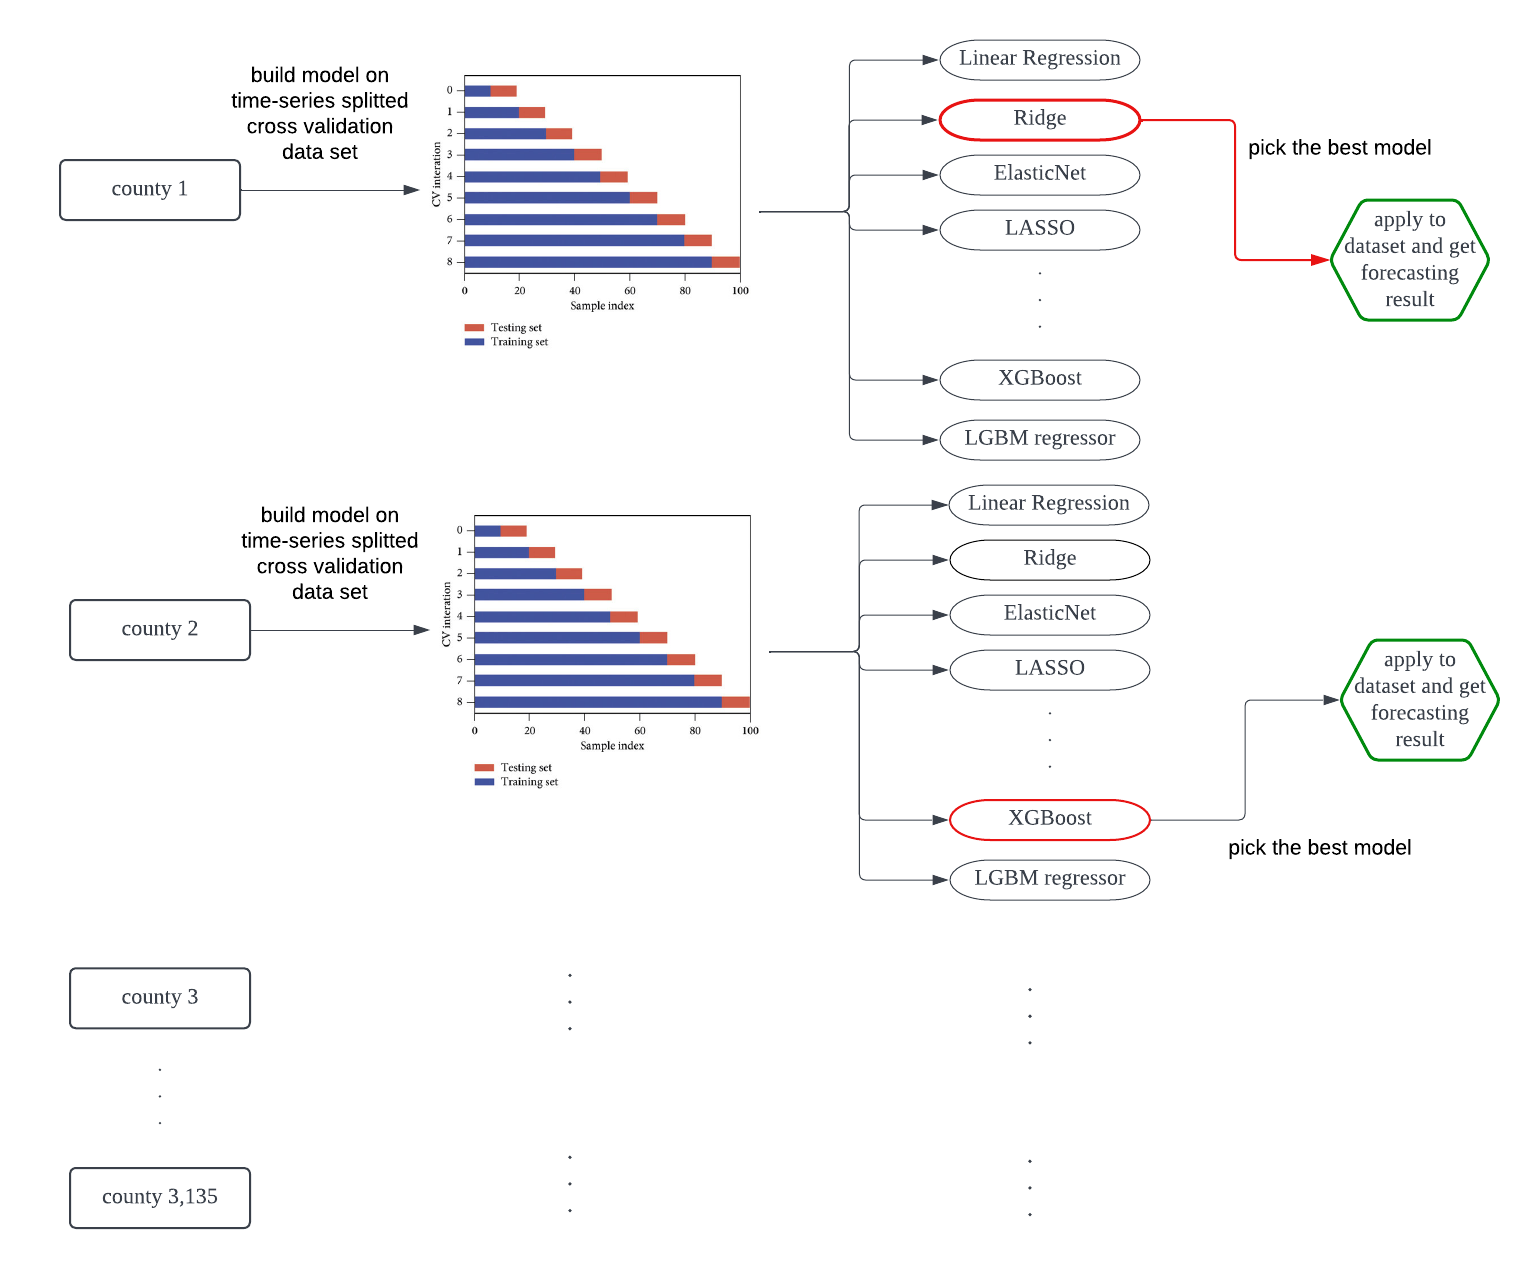

In [1]:
# Plz install these packages if you want to make choropleth map.
# !pip install plotly-geo
# !pip install pyshp
# !pip install geopandas

In [2]:
# if Pip does not work, please try conda install as below
# conda install -c plotly plotly-geo

In [3]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 500)

import plotly.figure_factory as ff
import geopandas
import shapely
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit

In [1]:
# load dataset

df_train = pd.read_csv(r"C:\Users\Slmss\OneDrive\Desktop\A.I. Factory\Freelancing\Kaggle\GoDaddy - Microbusiness Density Forecasting\Data\train.csv")
df_test = pd.read_csv(r"C:\Users\Slmss\OneDrive\Desktop\A.I. Factory\Freelancing\Kaggle\GoDaddy - Microbusiness Density Forecasting\Data\test.csv")
df_census = pd.read_csv(r"C:\Users\Slmss\OneDrive\Desktop\A.I. Factory\Freelancing\Kaggle\GoDaddy - Microbusiness Density Forecasting\Data\census_starter.csv")

NameError: name 'pd' is not defined

In [5]:
# combine train and testset
df_train['dataset'] = 'train'
df_test['dataset'] = 'test'
df = pd.concat((df_train, df_test)).sort_values('row_id').reset_index(drop=True)

In [6]:
# merge census data with train-test dataset. 
df_all = df.merge(df_census, on = 'cfips', how='left')

In [7]:
df_all.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,dataset,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,10001_2019-08-01,10001,Kent County,Delaware,01-08-2019,4.995701,6624.0,train,80.8,83.3,85.2,87.0,88.6,14.5,14.6,14.7,15.2,15.6,6.0,5.7,6.1,6.2,6.2,1.3,1.2,1.2,1.2,0.9,57647,58775.0,60910,60117.0,63715.0
1,10001_2019-09-01,10001,Kent County,Delaware,01-09-2019,5.031902,6672.0,train,80.8,83.3,85.2,87.0,88.6,14.5,14.6,14.7,15.2,15.6,6.0,5.7,6.1,6.2,6.2,1.3,1.2,1.2,1.2,0.9,57647,58775.0,60910,60117.0,63715.0
2,10001_2019-10-01,10001,Kent County,Delaware,01-10-2019,5.098270,6760.0,train,80.8,83.3,85.2,87.0,88.6,14.5,14.6,14.7,15.2,15.6,6.0,5.7,6.1,6.2,6.2,1.3,1.2,1.2,1.2,0.9,57647,58775.0,60910,60117.0,63715.0
3,10001_2019-11-01,10001,Kent County,Delaware,01-11-2019,5.124666,6795.0,train,80.8,83.3,85.2,87.0,88.6,14.5,14.6,14.7,15.2,15.6,6.0,5.7,6.1,6.2,6.2,1.3,1.2,1.2,1.2,0.9,57647,58775.0,60910,60117.0,63715.0
4,10001_2019-12-01,10001,Kent County,Delaware,01-12-2019,5.086203,6744.0,train,80.8,83.3,85.2,87.0,88.6,14.5,14.6,14.7,15.2,15.6,6.0,5.7,6.1,6.2,6.2,1.3,1.2,1.2,1.2,0.9,57647,58775.0,60910,60117.0,63715.0


In [8]:
df_all['first_day_of_month'] = pd.to_datetime(df_all["first_day_of_month"])
df_all["year"] = df_all["first_day_of_month"].dt.year
df_all['month'] = df_all["first_day_of_month"].dt.month

In [9]:
# you can change the value under here to see the national trend in each elements.
fig = ff.create_choropleth(fips=df_census.cfips,title = 'pct_bb_2019', values=df_census.pct_bb_2019.values)
fig.layout.template = None
fig.show();

TypeError: 'MultiPolygon' object is not iterable

In [10]:
# add 2-year lag census data to each rows 

conditions = [df_all['year']==2019,df_all['year']==2020,df_all['year']==2021, df_all['year']==2022, df_all['year']==2023]
choices_bb = [df_all['pct_bb_2017'],df_all['pct_bb_2018'],df_all['pct_bb_2019'],df_all['pct_bb_2020'],df_all['pct_bb_2021'] ]
choices_college = [df_all['pct_college_2017'],df_all['pct_college_2018'],df_all['pct_college_2019'],
                   df_all['pct_college_2020'],df_all['pct_college_2021']]
choices_foreign = [df_all['pct_foreign_born_2017'],df_all['pct_foreign_born_2018'],df_all['pct_foreign_born_2019'],
                   df_all['pct_foreign_born_2020'],df_all['pct_foreign_born_2021']]
choices_workers = [df_all['pct_it_workers_2017'],df_all['pct_it_workers_2018'],df_all['pct_it_workers_2019'],
                   df_all['pct_it_workers_2020'],df_all['pct_it_workers_2021']]
choices_inc = [df_all['median_hh_inc_2017'],df_all['median_hh_inc_2018'],df_all['median_hh_inc_2019'],
               df_all['median_hh_inc_2020'],df_all['median_hh_inc_2021']]

In [11]:
df_all["pct_bb"] = np.select(conditions, choices_bb, default=np.nan)
df_all["pct_college"] = np.select(conditions, choices_college, default=np.nan)
df_all["pct_foreign"] = np.select(conditions, choices_foreign, default=np.nan)
df_all["pct_workers"] = np.select(conditions, choices_workers, default=np.nan)
df_all["pct_inc"] = np.select(conditions, choices_inc, default=np.nan)

In [12]:
# drop unnecessary columns
df_all.drop(['pct_bb_2017', 'pct_bb_2018',
       'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
       'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
       'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'], axis=1, inplace=True)

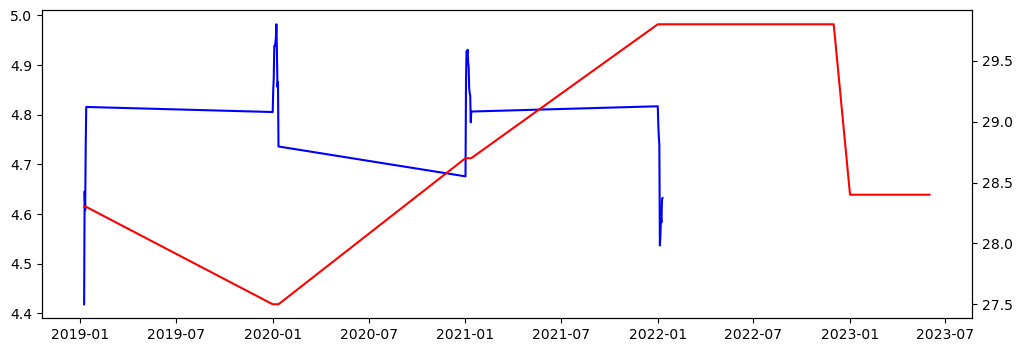

In [13]:
# let's see how '(2year-lag)pct_college' is related with micro-biz density
import matplotlib.pyplot as plt

test = df_all.set_index('first_day_of_month')
test = test[test['cfips']==56001]
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(test['microbusiness_density'], color='blue' , label='microbusiness_density')
ax2 = ax1.twinx()
ax2.plot(test['pct_college'], color='red' , label='college')

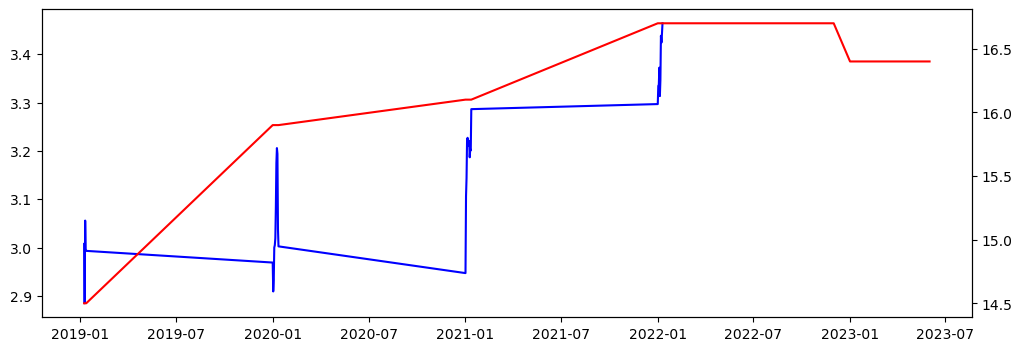

In [14]:
# randomly choose cfips == 1001 and 56001 (above)
test = df_all.set_index('first_day_of_month')
test = test[test['cfips']==1001]
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(test['microbusiness_density'], color='blue' , label='microbusiness_density')
ax2 = ax1.twinx()
ax2.plot(test['pct_college'], color='red' , label='college')

It's not easy to figure out how these variables are related with each other at a glance. Anyway, Let's move on to the next step.

In [15]:
# using pivot table to check the trend of micro-biz
train_pivoted = df_all.pivot(index='cfips',columns='first_day_of_month',values='microbusiness_density')

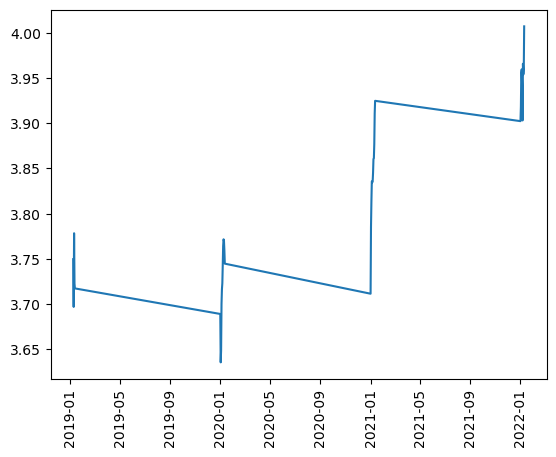

In [16]:
# micro-business density 

plt.plot(train_pivoted.mean(axis=0));
plt.xticks(rotation=90);

Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 
 
It seems like micro-business was affected by Covid-19 (where it dropped dramatically). However, 4 out of 100 people over the age of 18 in the given county running their own business Now.

In [17]:
# create function for MA and EWM
#SMA and EMA are both commonly-used trend indicators. SMA gives equal weight to all data points,  while EMA applies more weight to recent data points. 

def moving_average(df,i, n):
    MA = pd.Series(df[i].rolling(n, min_periods=n).mean(), name = 'MA_' + str(n))
    df = df.join(MA)
    return df

def weighted_moving_average(df,i, n):
    EMA = pd.Series(df[i].ewm(span=n, adjust=False, min_periods=n).mean(), name = 'EMA_' + str(n))
    df = df.join(EMA)
    return df

In [18]:
# generate time-series based variables.
# create Moving Average variable.
df_all = moving_average(df_all, 'microbusiness_density', 3)
df_all = moving_average(df_all, 'microbusiness_density', 6)

# actually it's Exponential Moving Average. 
df_all = weighted_moving_average(df_all, 'microbusiness_density', 3)
df_all = weighted_moving_average(df_all, 'microbusiness_density', 6)

In [19]:
# add 'pct_change_before' variable. This variable shows that how the density changed previous month.
df_all['pct_change_before'] = df_all['microbusiness_density'].pct_change().shift(1)

In [20]:
df_all.head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,dataset,year,month,pct_bb,pct_college,pct_foreign,pct_workers,pct_inc,MA_3,MA_6,EMA_3,EMA_6,pct_change_before
0,10001_2019-08-01,10001,Kent County,Delaware,2019-01-08,4.995701,6624.0,train,2019,1,80.8,14.5,6.0,1.3,57647.0,NaN,NaN,NaN,NaN,NaN
1,10001_2019-09-01,10001,Kent County,Delaware,2019-01-09,5.031902,6672.0,train,2019,1,80.8,14.5,6.0,1.3,57647.0,NaN,NaN,NaN,NaN,NaN
2,10001_2019-10-01,10001,Kent County,Delaware,2019-01-10,5.098270,6760.0,train,2019,1,80.8,14.5,6.0,1.3,57647.0,5.041958,NaN,5.056036,NaN,0.007246
3,10001_2019-11-01,10001,Kent County,Delaware,2019-01-11,5.124666,6795.0,train,2019,1,80.8,14.5,6.0,1.3,57647.0,5.084946,NaN,5.090351,NaN,0.013189
4,10001_2019-12-01,10001,Kent County,Delaware,2019-01-12,5.086203,6744.0,train,2019,1,80.8,14.5,6.0,1.3,57647.0,5.103046,NaN,5.088277,NaN,0.005178
5,10001_2020-01-01,10001,Kent County,Delaware,2020-01-01,5.017472,6734.0,train,2020,1,83.3,14.6,5.7,1.2,58775.0,5.076114,5.059036,5.052875,5.052563,-0.007505
6,10001_2020-02-01,10001,Kent County,Delaware,2020-01-02,5.056963,6787.0,train,2020,1,83.3,14.6,5.7,1.2,58775.0,5.053546,5.069246,5.054919,5.053820,-0.013513
7,10001_2020-03-01,10001,Kent County,Delaware,2020-01-03,5.083041,6822.0,train,2020,1,83.3,14.6,5.7,1.2,58775.0,5.052492,5.077769,5.068980,5.062169,0.007871
8,10001_2020-04-01,10001,Kent County,Delaware,2020-01-04,5.203746,6984.0,train,2020,1,83.3,14.6,5.7,1.2,58775.0,5.114583,5.095349,5.136363,5.102620,0.005157
9,10001_2020-05-01,10001,Kent County,Delaware,2020-01-05,5.206727,6988.0,train,2020,1,83.3,14.6,5.7,1.2,58775.0,5.164505,5.109025,5.171545,5.132364,0.023747


#### generate lagged data , lag1 means previous (one-month) month's mciro-biz density.

In [21]:

def lag_feature(df):
    for lag in range(1, 6):
        df[f'lag_density_{lag}'] = df.groupby('cfips')['microbusiness_density'].shift(lag)
        df[f'lag_density_{lag}'] = df.groupby('cfips')[f'lag_density_{lag}'].bfill()
        
    return df
    
df_all = lag_feature(df_all)

As I mentioned, we should consider **'national-wide' and 'state-wide' factors**, like average micro-business density in each state on each month or national average micro-business density each month. 

In [22]:
# the average microbusiness density in each state by month
# each month's national average microbusines_density 
df_all['national_avg'] = df_all.groupby(['year','month'])['microbusiness_density'].transform('mean')
df_all['state_avg'] = df_all.groupby(['state','year','month'])['microbusiness_density'].transform('mean')

In [23]:
# example 
df_all[df_all['cfips']==47081].head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,dataset,year,month,pct_bb,pct_college,pct_foreign,pct_workers,pct_inc,MA_3,MA_6,EMA_3,EMA_6,pct_change_before,lag_density_1,lag_density_2,lag_density_3,lag_density_4,lag_density_5,national_avg,state_avg
106173,47081_2019-08-01,47081,Hickman County,Tennessee,2019-01-08,2.675777,513.0,train,2019,1,53.7,7.0,0.9,2.0,39333.0,NaN,NaN,2.674302,2.620634,0.000000,2.675777,2.675777,2.675777,2.675777,2.675777,3.732905,3.211676
106174,47081_2019-09-01,47081,Hickman County,Tennessee,2019-01-09,2.607970,500.0,train,2019,1,53.7,7.0,0.9,2.0,39333.0,NaN,NaN,2.641136,2.617016,0.168225,2.675777,2.675777,2.675777,2.675777,2.675777,3.732905,3.211676
106175,47081_2019-10-01,47081,Hickman County,Tennessee,2019-01-10,2.733153,524.0,train,2019,1,53.7,7.0,0.9,2.0,39333.0,2.672300,NaN,2.687144,2.650198,-0.025341,2.607970,2.675777,2.675777,2.675777,2.675777,3.732905,3.211676
106176,47081_2019-11-01,47081,Hickman County,Tennessee,2019-01-11,2.738368,525.0,train,2019,1,53.7,7.0,0.9,2.0,39333.0,2.693164,NaN,2.712756,2.675389,0.048000,2.733153,2.607970,2.675777,2.675777,2.675777,3.732905,3.211676
106177,47081_2019-12-01,47081,Hickman County,Tennessee,2019-01-12,2.701857,518.0,train,2019,1,53.7,7.0,0.9,2.0,39333.0,2.724459,NaN,2.707307,2.682951,0.001908,2.738368,2.733153,2.607970,2.675777,2.675777,3.732905,3.211676
106178,47081_2020-01-01,47081,Hickman County,Tennessee,2020-01-01,2.660593,514.0,train,2020,1,57.3,7.4,1.2,1.6,41998.0,2.700273,2.686286,2.683950,2.676563,-0.013333,2.701857,2.738368,2.733153,2.607970,2.675777,3.722057,3.210620
106179,47081_2020-02-01,47081,Hickman County,Tennessee,2020-01-02,2.645064,511.0,train,2020,1,57.3,7.4,1.2,1.6,41998.0,2.669172,2.681168,2.664507,2.667564,-0.015272,2.660593,2.701857,2.738368,2.733153,2.607970,3.722057,3.210620
106180,47081_2020-03-01,47081,Hickman County,Tennessee,2020-01-03,2.588126,500.0,train,2020,1,57.3,7.4,1.2,1.6,41998.0,2.631261,2.677860,2.626316,2.644867,-0.005837,2.645064,2.660593,2.701857,2.738368,2.733153,3.722057,3.210620
106181,47081_2020-04-01,47081,Hickman County,Tennessee,2020-01-04,2.629536,508.0,train,2020,1,57.3,7.4,1.2,1.6,41998.0,2.620909,2.660591,2.627926,2.640487,-0.021526,2.588126,2.645064,2.660593,2.701857,2.738368,3.722057,3.210620
106182,47081_2020-05-01,47081,Hickman County,Tennessee,2020-01-05,2.634712,509.0,train,2020,1,57.3,7.4,1.2,1.6,41998.0,2.617458,2.643315,2.631319,2.638837,0.016000,2.629536,2.588126,2.645064,2.660593,2.701857,3.722057,3.210620


### create target variable
Now, we need to create target column. 
As we are trying to predict the next month's micro-biz density,
we should shift the 'microbusiness_density' variables like below.

In [24]:
df_all['target'] = df_all.groupby('cfips')['microbusiness_density'].shift(-1)

#### create function to check the table at a glance

In [25]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ


In [26]:
summary_table = summary(df_all)

data shape: (147345, 28)


In [27]:
# now you can check all variables at a glance.
summary_table

,data type,#missing,%missing,#unique,min,max,first value,second value,third value
row_id,object,0,0.000000,147345,NaN,NaN,10001_2019-08-01,10001_2019-09-01,10001_2019-10-01
cfips,int64,0,0.000000,3135,1001.0,56045.0,10001,10001,10001
county,object,2508000,0.170213,1871,NaN,NaN,Kent County,Kent County,Kent County
state,object,2508000,0.170213,51,NaN,NaN,Delaware,Delaware,Delaware
first_day_of_month,datetime64[ns],0,0.000000,47,NaN,NaN,2019-01-08 00:00:00,2019-01-09 00:00:00,2019-01-10 00:00:00
microbusiness_density,float64,2508000,0.170213,97122,0.0,284.34003,4.995701,5.031902,5.09827
active,float64,2508000,0.170213,19193,0.0,1167744.0,6624.0,6672.0,6760.0
dataset,object,0,0.000000,2,NaN,NaN,train,train,train
year,int64,0,0.000000,5,2019.0,2023.0,2019,2019,2019
month,int64,0,0.000000,8,1.0,12.0,1,1,1


### Modeling

In [28]:
# check columns
df_all.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'dataset', 'year', 'month', 'pct_bb',
       'pct_college', 'pct_foreign', 'pct_workers', 'pct_inc', 'MA_3', 'MA_6',
       'EMA_3', 'EMA_6', 'pct_change_before', 'lag_density_1', 'lag_density_2',
       'lag_density_3', 'lag_density_4', 'lag_density_5', 'national_avg',
       'state_avg', 'target'],
      dtype='object')

**Not all columns are need for prediction**. 
Definetely, we should exclude row_id, state, microbusiness_density etc. 

So the next step is exclude unnecessary columns.

#### let's choose one county as a sample and build a prediction model.

In [29]:
# choose one county 
sample = df_all[df_all['cfips']==9011]

In [30]:
# choose train data only
sample_train = sample[sample['dataset']=='train']

In [31]:
### split train X and Y
train_X = sample_train[['year', 'month', 'pct_bb',
       'pct_college', 'pct_foreign', 'pct_workers', 'pct_inc', 'MA_3', 'MA_6',
       'EMA_3', 'EMA_6', 'lag_density_1', 'lag_density_2',
       'lag_density_3', 'lag_density_4', 'lag_density_5', 'pct_change_before',
       'national_avg', 'state_avg']]
train_y = sample_train['target']

In [32]:
# fill na with 'bfill'
train_X.fillna(method='bfill', inplace=True)

### Time Series Split.
#### before we start, let's see the overview of time-series split.

In [33]:
# Function modified from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
from matplotlib.patches import Patch
cmap_cv = plt.cm.seismic
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
#     yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

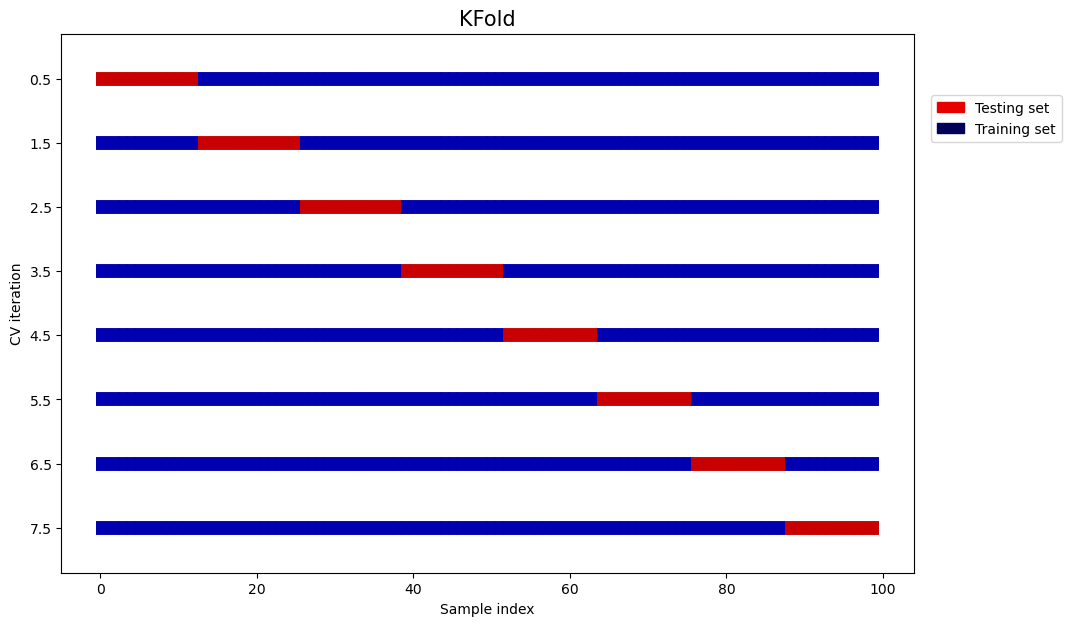

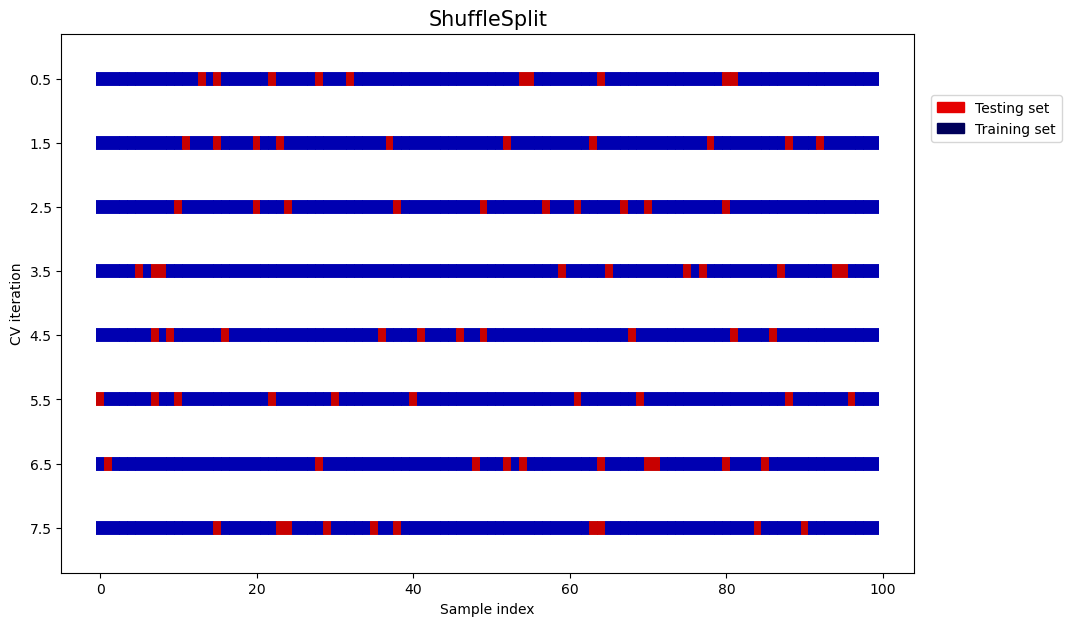

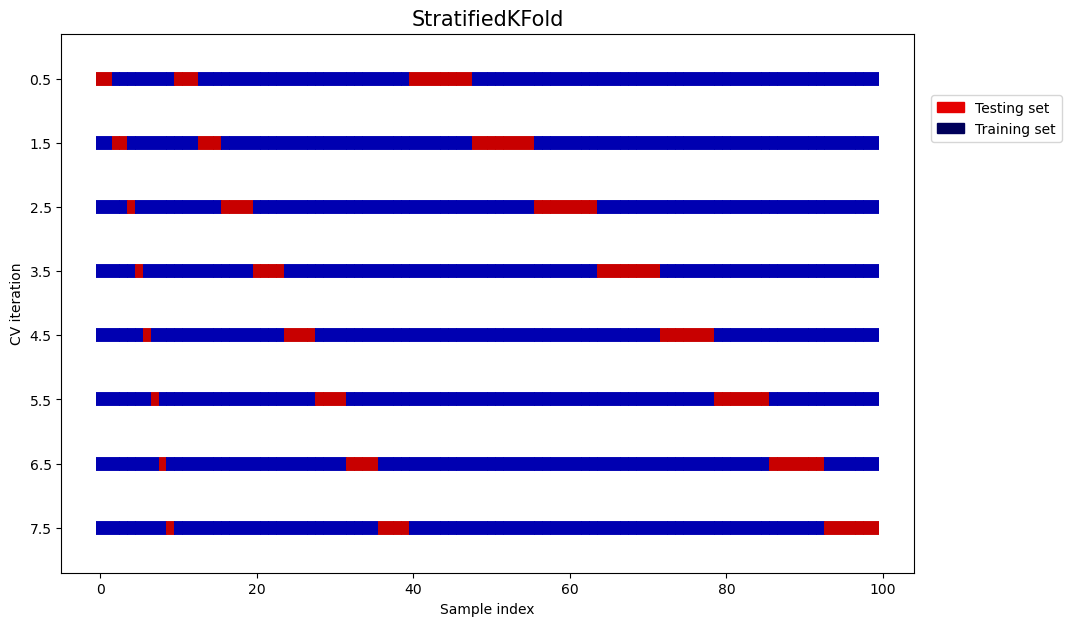

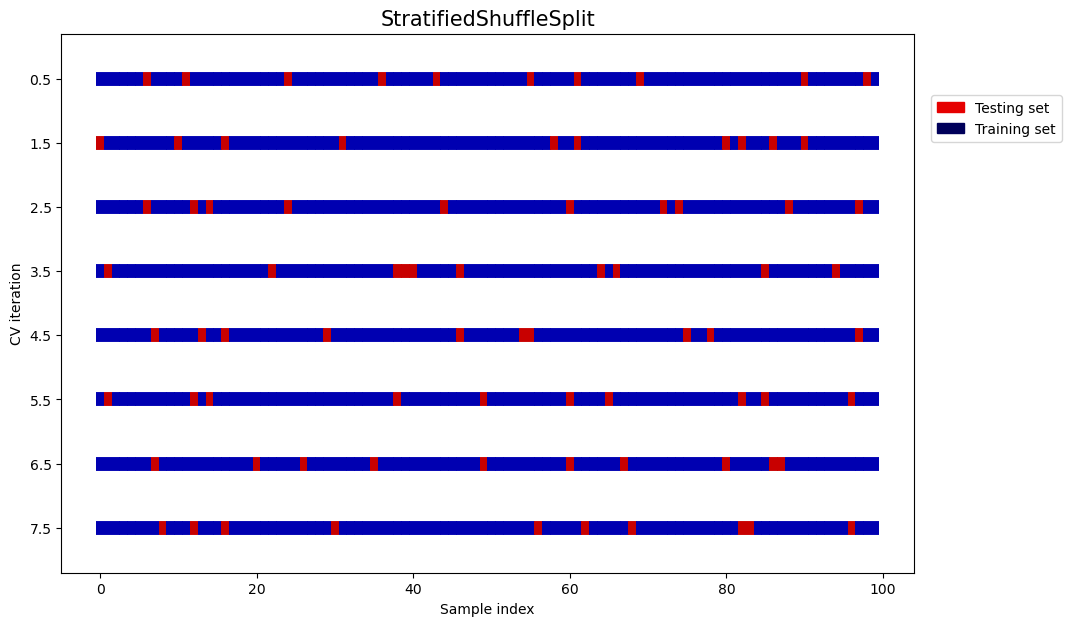

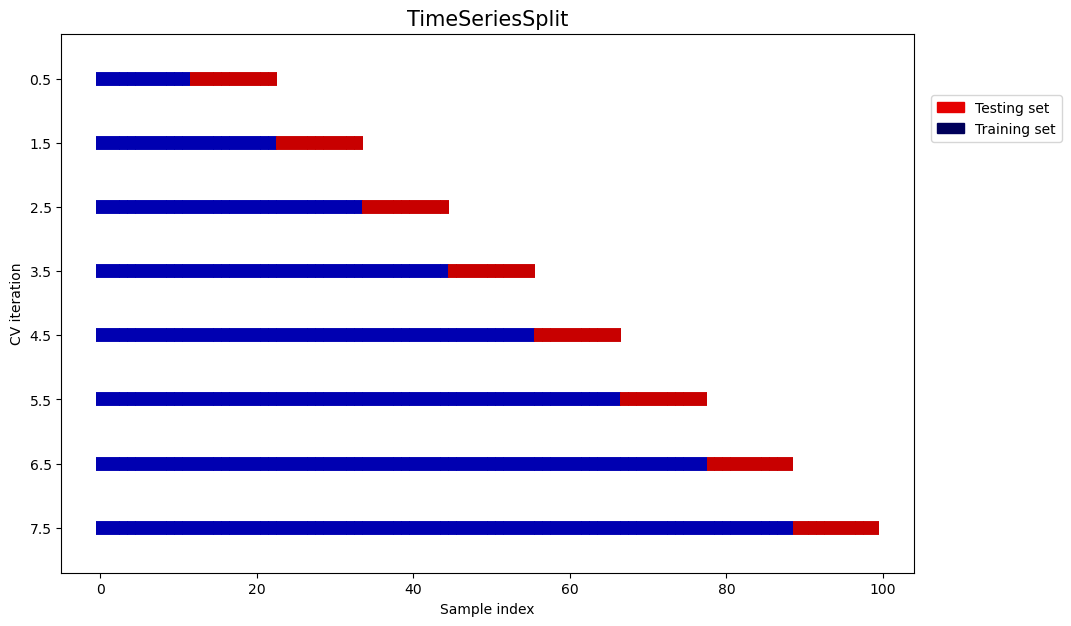

In [34]:
# time series split 
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
cvs = [KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit]
n_points = 100
n_splits = 8
X = np.random.randn(100, 10)
percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

for i, cv in enumerate(cvs):
    this_cv = cv(n_splits=n_splits)
    plot_cv_indices(this_cv, n_splits, X, y, date_col=None)

### If you are not using TimeSeriesSplit, It means that you are cheating future data during the training.
### To avoid data leakage like this, data scientist prefer using TimeSeriesSlit method, even though the size of traning data would become smaller than normal method.

In [35]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 7
tscv = TimeSeriesSplit(n_splits)

Fold: 0
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10] 
 TEST indices: [11 12 13 14]


Fold: 1
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
 TEST indices: [15 16 17 18]


Fold: 2
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
 TEST indices: [19 20 21 22]


Fold: 3
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] 
 TEST indices: [23 24 25 26]


Fold: 4
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] 
 TEST indices: [27 28 29 30]


Fold: 5
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] 
 TEST indices: [31 32 33 34]


Fold: 6
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34] 
 TEST indices: [35 36 37 38]




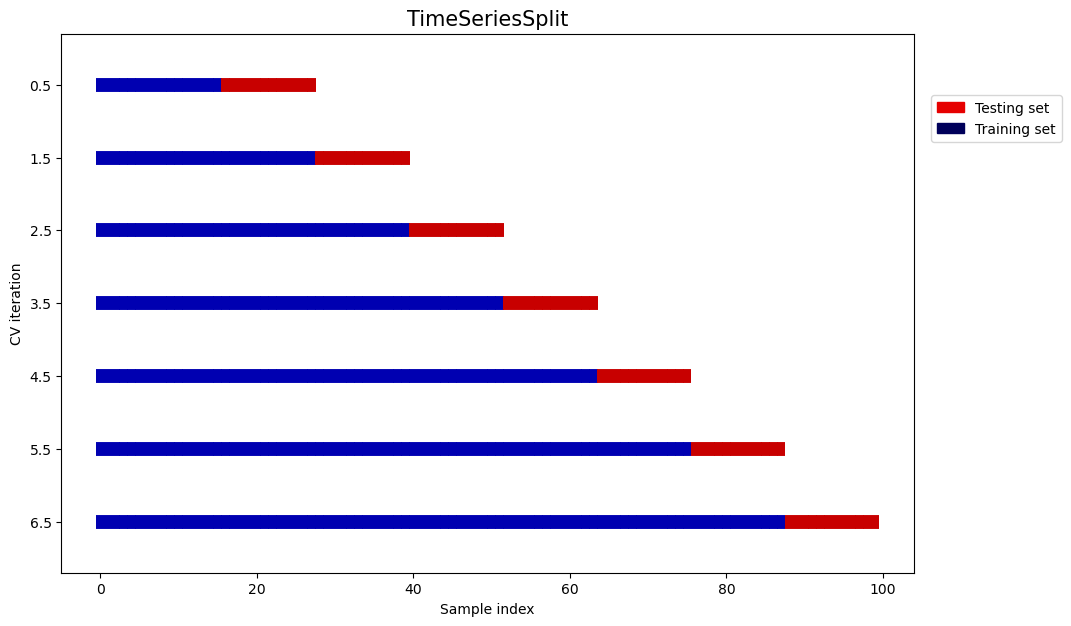

In [36]:
# In our case, data point is 39, so it would be splited like below
# (example taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py )

for fold, (train_index, test_index) in enumerate(tscv.split(sample[sample['dataset']=='train'])):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    print("\n")
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]


plot_cv_indices(tscv,n_splits, X, y)

### create evaluation metrics
Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors. 
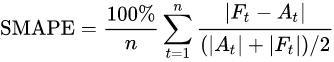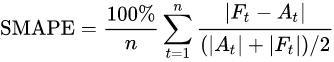

Advantages of SMAPE :
- Expressed as a percentage, therefore easy to interpret
- Fixes the shortcoming of the original MAPE. it has both the lower (0%) and the upper (200%) bounds.

In [37]:
# create custom function
def SMAPE(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [38]:
def smape_cv(model):
    tscv = TimeSeriesSplit(n_splits=7)
    smape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), 
                                             desc=f'{model_name} Cross Validations', total=7):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        smape = SMAPE(y_test, pred) 
        smape_list.append(smape)
    return model_name, smape_list

def print_smape_score(model):
    # print cv and save the average
    model_name, score = smape_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} smape: {r:.4f}')
    print(f'\n{model_name} mean smape: {np.mean(score):.4f}')
    print('='*30)
    return model_name, np.mean(score)

In [42]:
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Elastic = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
RF = RandomForestRegressor(n_estimators=500,  max_depth=5, min_samples_split=2,
                           min_samples_leaf=2, random_state=1, n_jobs=-1)
XGB = xgb.XGBRegressor(n_estimators=500, max_depth=5, min_child_weight=5, gamma=0.1, n_jobs=-1)
LGBM = lgb.LGBMRegressor(n_estimators=500, max_depth=5, min_child_weight=5, n_jobs=-1)

In [43]:
models = []
scores = []
for model in [reg, ridge, lasso, Elastic, RF, XGB, LGBM]:
    model_name, mean_score = print_smape_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations: 100%|███████████████████████████████████████████████| 7/7 [00:00<00:00, 123.08it/s]


1 FOLDS: LinearRegression smape: 12.1766
2 FOLDS: LinearRegression smape: 1.1481
3 FOLDS: LinearRegression smape: 0.1640
4 FOLDS: LinearRegression smape: 1.0825
5 FOLDS: LinearRegression smape: 1.2203
6 FOLDS: LinearRegression smape: 0.8887
7 FOLDS: LinearRegression smape: 0.5240

LinearRegression mean smape: 2.4578


Ridge Cross Validations: 100%|██████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 140.38it/s]


1 FOLDS: Ridge smape: 2.7496
2 FOLDS: Ridge smape: 0.2924
3 FOLDS: Ridge smape: 0.4379
4 FOLDS: Ridge smape: 1.0748
5 FOLDS: Ridge smape: 0.7256
6 FOLDS: Ridge smape: 0.7634
7 FOLDS: Ridge smape: 0.8972

Ridge mean smape: 0.9915


Lasso Cross Validations: 100%|██████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 149.24it/s]


1 FOLDS: Lasso smape: 2.7122
2 FOLDS: Lasso smape: 0.2686
3 FOLDS: Lasso smape: 0.5871
4 FOLDS: Lasso smape: 1.2851
5 FOLDS: Lasso smape: 0.9317
6 FOLDS: Lasso smape: 0.7325
7 FOLDS: Lasso smape: 1.0729

Lasso mean smape: 1.0843


ElasticNet Cross Validations: 100%|█████████████████████████████████████████████████████| 7/7 [00:00<00:00, 125.33it/s]


1 FOLDS: ElasticNet smape: 2.7829
2 FOLDS: ElasticNet smape: 0.3462
3 FOLDS: ElasticNet smape: 0.4403
4 FOLDS: ElasticNet smape: 1.1185
5 FOLDS: ElasticNet smape: 0.7743
6 FOLDS: ElasticNet smape: 0.7647
7 FOLDS: ElasticNet smape: 0.9494

ElasticNet mean smape: 1.0252


RandomForestRegressor Cross Validations: 100%|███████████████████████████████████████████| 7/7 [00:07<00:00,  1.06s/it]


1 FOLDS: RandomForestRegressor smape: 3.2063
2 FOLDS: RandomForestRegressor smape: 0.6523
3 FOLDS: RandomForestRegressor smape: 0.7802
4 FOLDS: RandomForestRegressor smape: 1.6781
5 FOLDS: RandomForestRegressor smape: 1.2019
6 FOLDS: RandomForestRegressor smape: 0.8155
7 FOLDS: RandomForestRegressor smape: 1.1199

RandomForestRegressor mean smape: 1.3506


XGBRegressor Cross Validations: 100%|████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.59it/s]


1 FOLDS: XGBRegressor smape: 2.7382
2 FOLDS: XGBRegressor smape: 1.1800
3 FOLDS: XGBRegressor smape: 2.0843
4 FOLDS: XGBRegressor smape: 2.7230
5 FOLDS: XGBRegressor smape: 3.0301
6 FOLDS: XGBRegressor smape: 3.0284
7 FOLDS: XGBRegressor smape: 2.6581

XGBRegressor mean smape: 2.4917


LGBMRegressor Cross Validations: 100%|███████████████████████████████████████████████████| 7/7 [00:00<00:00, 38.78it/s]

1 FOLDS: LGBMRegressor smape: 2.7382
2 FOLDS: LGBMRegressor smape: 1.1800
3 FOLDS: LGBMRegressor smape: 2.0843
4 FOLDS: LGBMRegressor smape: 2.7230
5 FOLDS: LGBMRegressor smape: 3.3584
6 FOLDS: LGBMRegressor smape: 3.3670
7 FOLDS: LGBMRegressor smape: 3.2984

LGBMRegressor mean smape: 2.6785


#### For New London County in Connecticut, test score looks not bad. 

## What's Next?
Each county's time series might has different trend. 
Theoretically, the best way is test each time series and choose the best model.
(It might take a lot of time, as it should train tons of models)

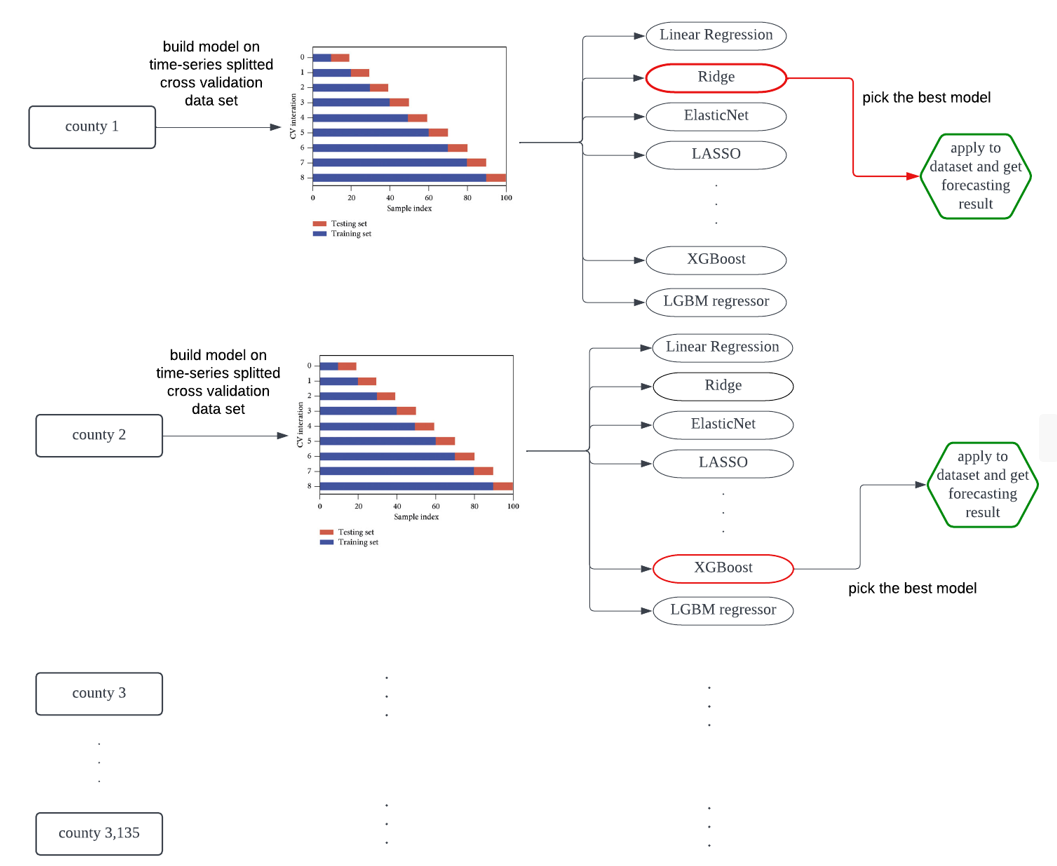

